**Install dependencies:** In case this notebook is not running [Carto-Lab Docker](https://cartolab.theplink.org/), the cell below aims to install the needed packages for this notebook. If packages are already available, they will be ignored.

In [1]:
import sys
pyexec = sys.executable
print(f"Current Kernel {pyexec}")
!../py/modules/pkginstall.sh "{pyexec}" geopandas folium

Current Kernel /opt/conda/envs/worker_env/bin/python3.13
geopandas already installed (version 1.0.1).
folium already installed (version 0.19.5).


# Creating Maps

```{admonition} Summary
:class: hint
This section focuses on visualizing spatial data, combining data from various sources and spatial data types into informative maps with elements like legends and titles. We will also explore creating interactive maps within Jupyter that allow for zooming and panning.
```

## Data retrieval


```{admonition} Data Retrieval
:class: warning
Make sure you ran notebook `301_accessing_data.ipynb` at least once to retrieve and setup the data needed for this notebook ([follow this link](content:references:datasetupreferencedocs)).
```

To visualize the data, load it using the `geopandas` package as demonstrated previously. The `.plot()` function provides a straightforward way to visualize your GeoDataFrame.

In [2]:
import geopandas as gp
from pathlib import Path

INPUT = Path.cwd().parents[0] / "00_data"
gdb_path = INPUT / "Biotopwerte_Dresden_2018.gdb"
gdf = gp.read_file(gdb_path, layer="Biotopwerte_Dresden_2018")

/opt/conda/envs/worker_env/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


## Basic plotting with geopandas

Using the `.plot()` function without any additional arguments will generate a simple, static plot of your spatial data with default styling.

In [3]:
filter_db = gdf[gdf['Shape_Area'] < 1000]
filter_db.plot()

<Axes: >

## Customizing static plots

To enhance the visualization, the `.plot()` function offers several parameters for customization:

- `linewidth`: Controls the thickness of the feature boundaries.
- `color`: Sets the fill color of the geometric shapes.
- `edgecolor`: Defines the color of the boundaries of the shapes.
- `ax.set_title()`: Sets the title of the plot.
- `ax.set_axis_off()`: Hides the plot axes.

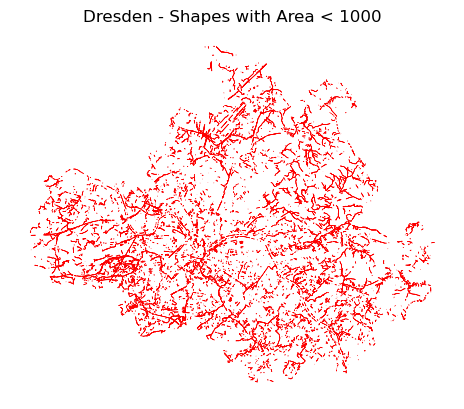

In [4]:
ax = filter_db.plot(linewidth=0.5, edgecolor='red')
ax.set_title("Dresden - Shapes with Area < 1000")
ax.set_axis_off()

## Advanced plot customization with matplotlib

For more fine-grained control over the plot's appearance, it's recommended to create a `matplotlib` figure and axes objects explicitly. 

In [5]:
import matplotlib.pyplot as plt

Then by defining different parameters for figure and subplots the visualization are customized. 

Key `matplotlib` components:

- `Figure (fig)`: The top-level container for all plot elements.
- `Subplot (ax)`: An individual plotting area within the figure.
- `nrows, ncols`: Define the grid of subplots within the figure.
- `figsize`: Specifies the size of the figure in inches (width, height).
- `dpi`: Sets the resolution of the figure (dots per inch).

The `ax` parameter in the `.plot()` function is used to specify which subplot the GeoDataFrame should be plotted onto.

**How the `ax` parameter works**

When creating multiple subplots, the `ax` parameter directs the plot to a specific subplot. For example:

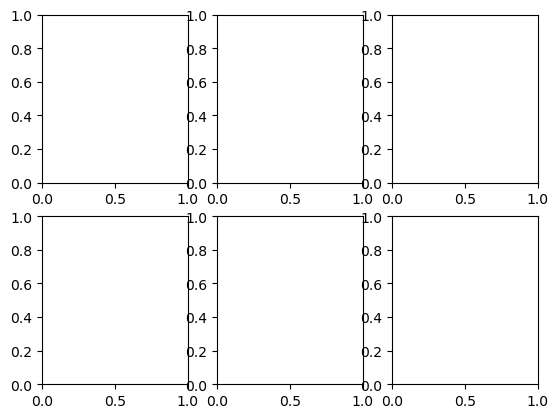

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=3) # Creates 6 subplots

ax1 = ax[0, 0]  # First row, first column
ax2 = ax[0, 1]  # First row, second column
ax3 = ax[0, 2]  # First row, third column
ax4 = ax[1, 0]  # Second row, first column
ax5 = ax[1, 1]  # Second row, second column
ax6 = ax[1, 2]  # Second row, third column

# Example plotting onto specific subplots:
# filter_db.plot(ax=ax3, linewidth=0.5, edgecolor='red')
# ax3.set_title("Figure 3")
# filter_db.plot(ax=ax4, linewidth=0.3, edgecolor='blue')
# ax4.set_title("Figure 4")

**Single subplot example:**

In [7]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(12, 18), dpi=300)
ax = filter_db.plot(ax=ax, linewidth=0.5, edgecolor='orange')
ax.set_title("Dresden - Shapes with Area < 1000")
ax.set_axis_off()

## Plotting selected features

You can plot specific rows from your GeoDataFrame using the `.loc` and `.iloc` indexers.

**`loc` vs `iloc`**

- `.loc[]`: Selects rows based on their index labels.
- `.iloc[]`: Selects rows based on their integer position (starting from 0).




`````{admonition} Example: .loc vs .iloc
:class: hint, dropdown

Dataset:

| index  |    Name     |   Age  |
| :------| ----------- |------: |
|    A   |   user1     |    15  |
|    B   |   user2     |    16  |
|    C   |   user3     |    30  |


- Using `.loc`.

output_1 = Dataset.loc['B']


| index  |    Name     |   Age  |
| :------| ----------- |------: |
|    B   |   user2     |    16  |



- Using `.iloc`.

output_2 = Dataset.iloc[1] # Indexing starts at 0


| index  |    Name     |   Age  |
| :------| ----------- |------: |
|    B   |   user2     |    16  |

`````

**Extracting and plotting specific rows**

Extract one row from dataset:

In [8]:
gdf_rows = gdf.loc[[100]] 
ax=gdf_rows.plot(color='purple')
ax.set_axis_off()

Extract a list of rows from dataset:

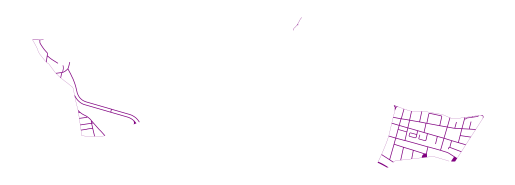

In [9]:
gdf_rows = gdf.loc[[100,101,123,148]] 
ax=gdf_rows.plot(color='purple')
ax.set_axis_off()

Extract a range of rows from dataset:

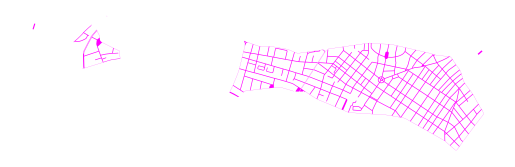

In [10]:
gdf_rows = gdf.loc[100:111]
ax=gdf_rows.plot(color='magenta')
ax.set_axis_off()

## Plotting features within a bounding box

You can focus your map on a specific geographic area by defining a bounding box.

**Defining the bounding box**

A bounding box is defined by four values:

- `lonmin`: Minimum longitude (left boundary)
- `latmin`: Minimum latitude (lower boundary)
- `lonmax`: Maximum longitude (right boundary)
- `latmax`: Maximum latitude (upper boundary)
  
These values can be defined manually or extracted from a subset of your data using the `.total_bounds` attribute.

In [11]:
lonmin, latmin, lonmax, latmax = gdf[100:110].total_bounds # rows 100 to 110
print(lonmin, latmin, lonmax, latmax)

409469.5248999996 5654741.2675 416922.3970999997 5656956.8463


**Filtering features within the bounding box**

To select geometries that **completely** fall within the defined bounding box, you can use boolean indexing based on the `.bounds` attribute of the geometry column:


In [12]:
gdf_filtered = gdf[
    (gdf.geometry.bounds.minx >= lonmin) & 
    (gdf.geometry.bounds.maxx <= lonmax) & 
    (gdf.geometry.bounds.miny >= latmin) & 
    (gdf.geometry.bounds.maxy <= latmax)]

ax = gdf_filtered.plot(color='skyblue',edgecolor='navy')
ax.set_title("Filtered data that completely fall within the defined bounding box")
ax.set_axis_off()

`````{admonition} Tip
:class: tip
Another method for displaying features within a bounding box involves the clipping function, which will be discussed in the "Clipping Data" (https://stag.hack.conference.ioer.info/notebooks/307_spatial_clipping.html#clipping-based-on-the-bounding-box) section.

`````

## Styling plots with legends and colormaps

To create more informative maps, you can style the features based on their attribute values using colormaps and add legends.

- `column`: shows the column that is mapped to color.
- `cmap`: defines the [color map](https://matplotlib.org/stable/gallery/color/colormap_reference.html#reverse-cmap).
- `legend = True`: adds the legend.
- `legend_kwds`: adds the legend label and defines the orientation.

**Plotting based on string values**

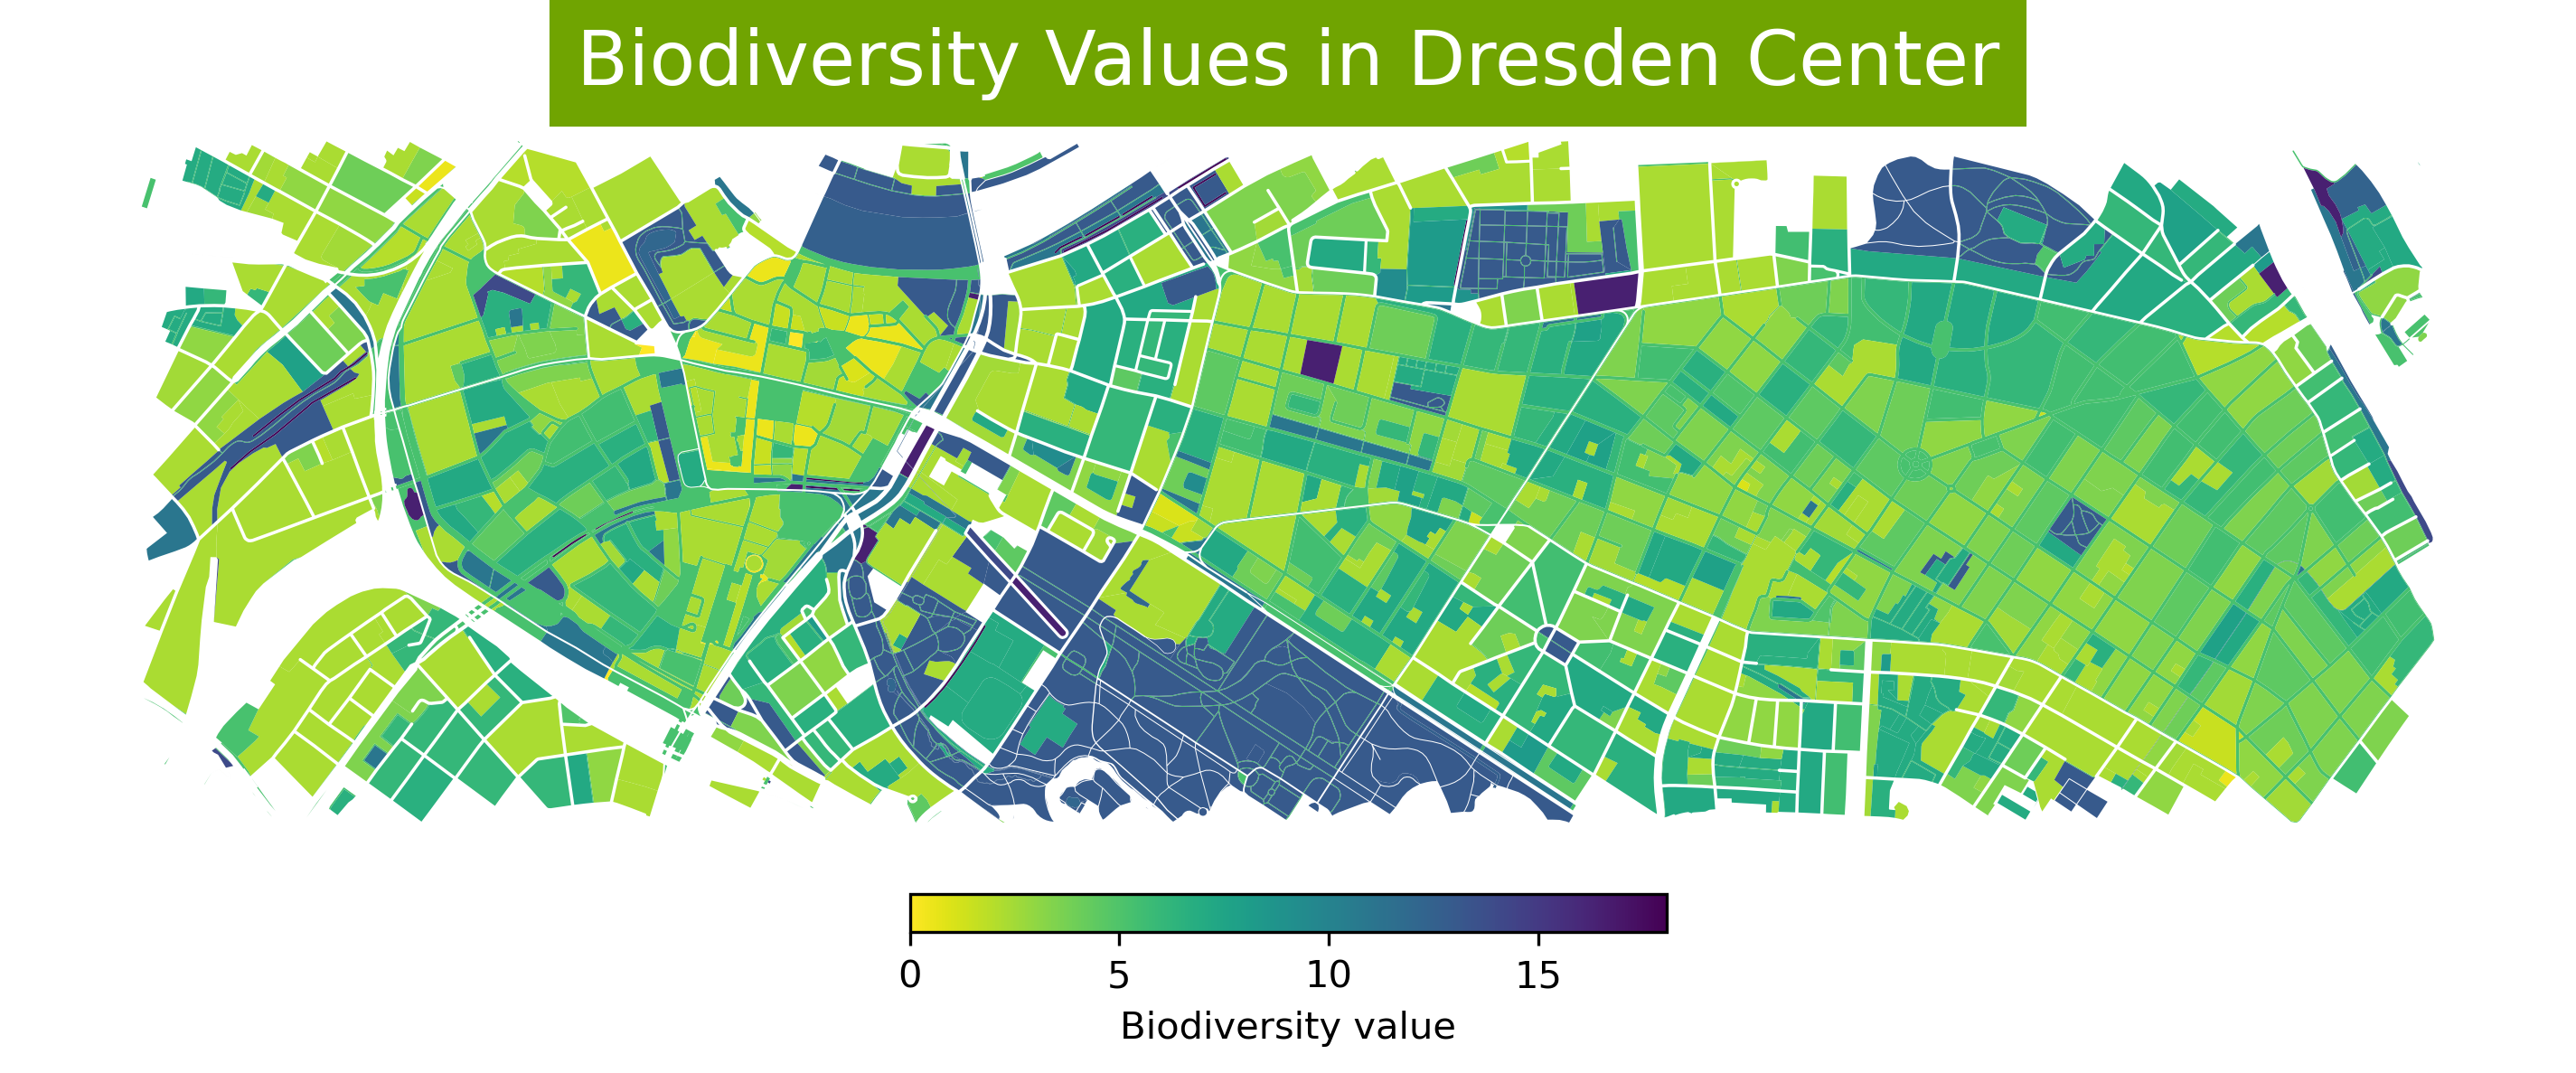

In [13]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(12, 18), dpi=300)

ax = gdf_filtered.plot(
    ax=ax,
    column='Biotpkt2018', 
    cmap='viridis_r',
    legend=True,
    legend_kwds={
        "label": "Biodiversity value",
        "orientation": "horizontal", 
        "shrink": 0.3, "pad": 0.01})

ax.set_title('Biodiversity Values in Dresden Center',
             backgroundcolor='#70A401', 
             color='white', fontsize=20)
ax.set_axis_off()

**Saving the plot as an svg**

In [14]:
OUTPUT = Path.cwd().parents[0] / "out"
OUTPUT.mkdir(exist_ok=True)

fig.savefig(
    Path.cwd().parents[0] / "out" / "biodiversity_dresden.svg", format='svg',
    bbox_inches='tight', pad_inches=0.1, facecolor="white")

**Plotting based on numeric values**

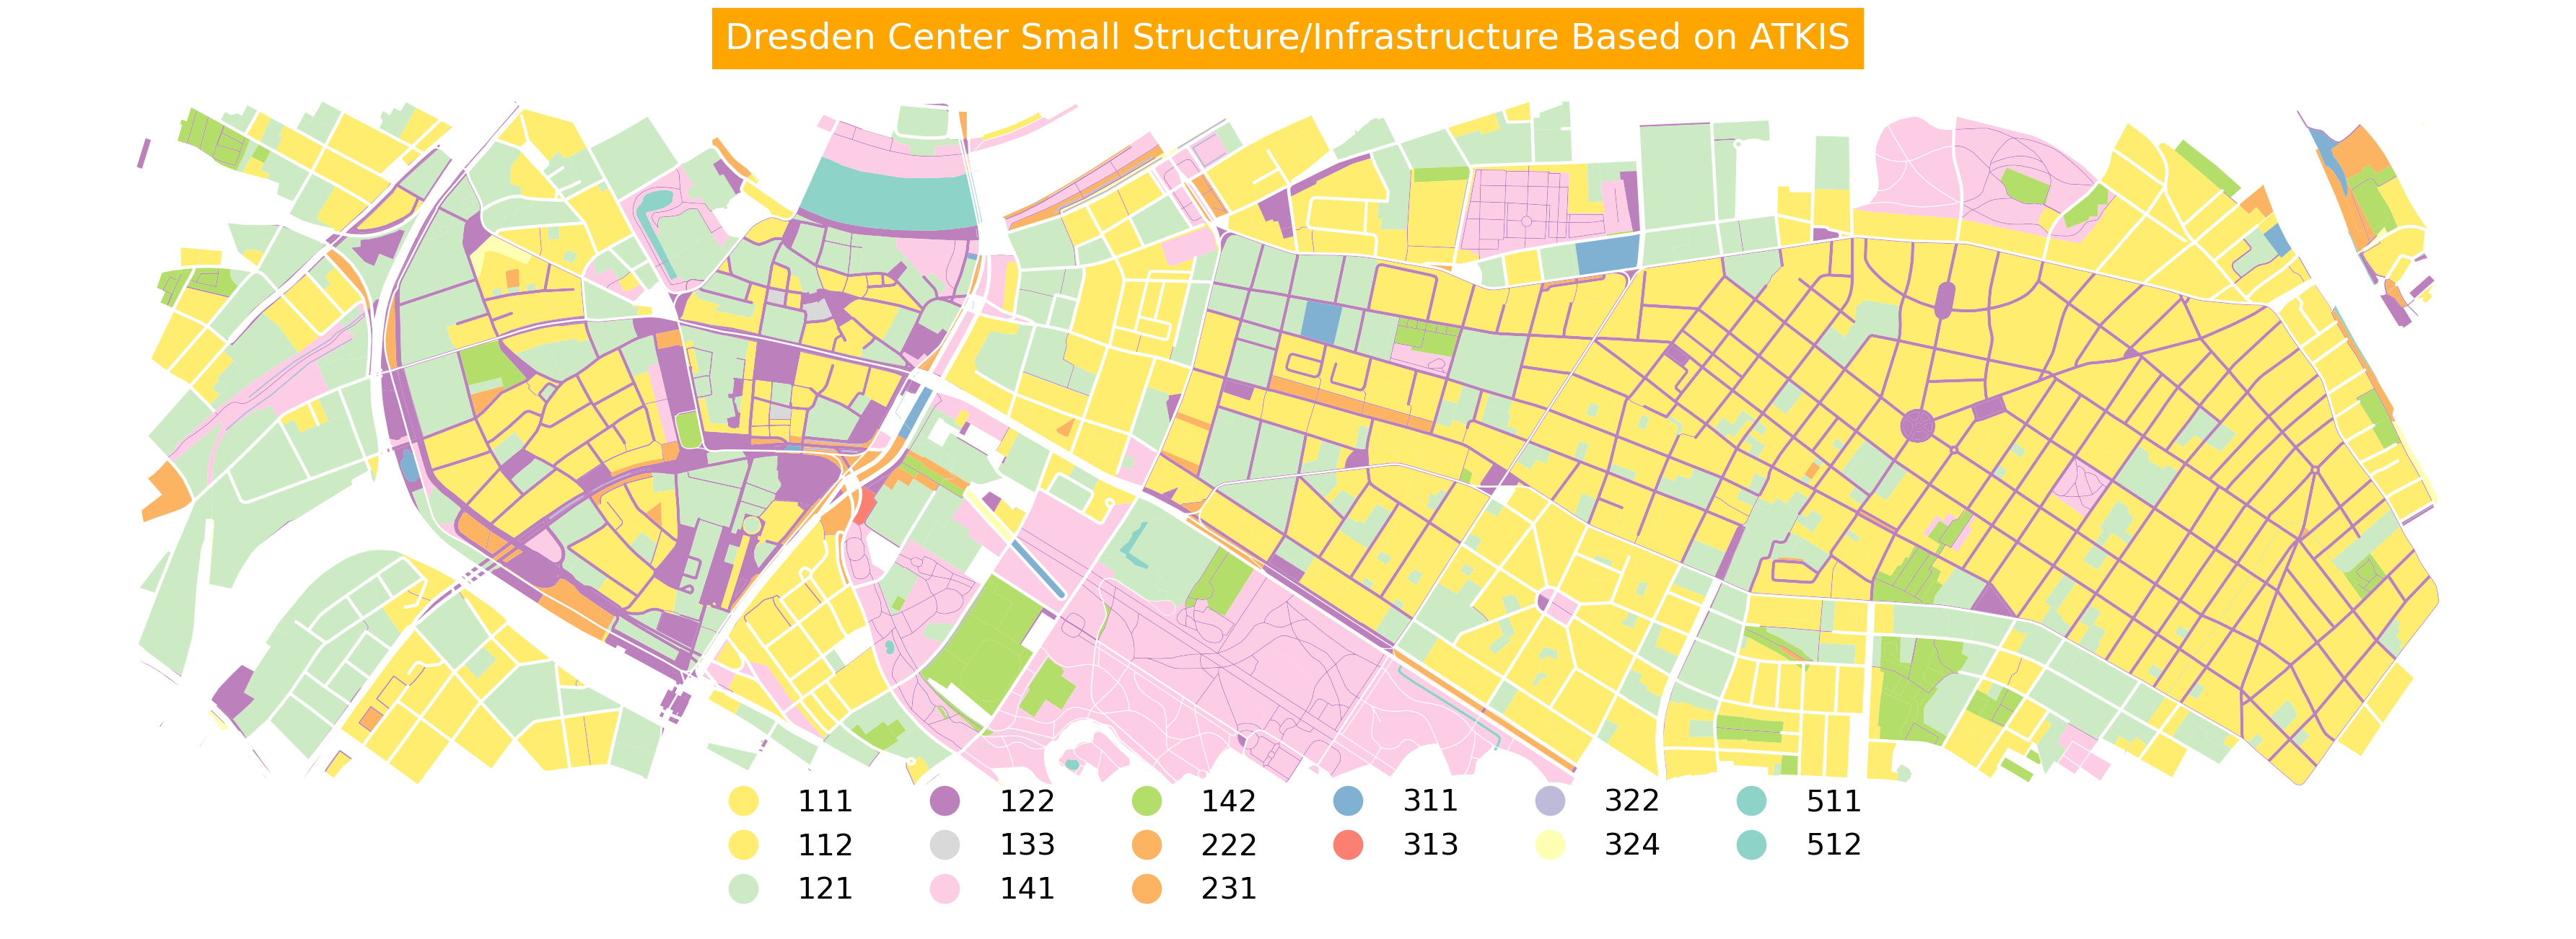

In [15]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(12, 18), dpi=300)

ax = gdf_filtered.plot(
    ax=ax,
    column='CLC_st1', 
    cmap='Set3_r',
    legend=True,
    legend_kwds={
        "loc": "lower center",
        "bbox_to_anchor": (0.5, -0.15),
        "ncol": 6,
        "frameon": False,
        "fontsize": 10
    })

ax.set_title('Dresden Center Small Structure/Infrastructure Based on ATKIS',
             backgroundcolor='orange',
             color='white')
ax.set_axis_off()
# Ensure room below the plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for legend

Above, we use `legend_kwds` to modify the look and style of the default matplotlib legend. [There are many parameters](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html). We used:

- **loc**: Legend position reference  
- **bbox_to_anchor**: Exact legend placement coordinates  
- **ncol**: Number of columns in legend  
- **frameon**: Show/hide legend box  
- **fontsize**: Size of legend text  

## Interactive filtering with a slider

You can create interactive visualizations within Jupyter using widgets, allowing users to dynamically filter the displayed data.

In [16]:
import ipywidgets as widgets
from ipywidgets import interact

Define a function to filter and plot the data based on a slider value:

In [17]:
def ShapeArea(value):
    filtered_gdf = gdf[gdf['Shape_Area'] <= value]
    ax= filtered_gdf.plot()
    ax.set_axis_off()
    plt.show()  

Create an interactive slider linked to the `ShapeArea` function:

In [18]:
interact(ShapeArea, value=widgets.FloatSlider(min=20000, max=70000, step=0.1));

interactive(children=(FloatSlider(value=20000.0, description='value', max=70000.0, min=20000.0), Output()), _d…

In [19]:
from IPython.display import HTML

HTML('''
<video autoplay loop muted style="border: 5px solid black; border-radius: 10px; max-width: 100%;">
  <source src="../_static/videos/Video3.webm" type="video/webm" />
  Your browser does not support the video tag.
</video>
<figcaption>Interactive filtering</figcaption>
''')

## Adding a basemap for context

The [folium library](https://realpython.com/python-folium-web-maps-from-data/) ibrary allows you to create interactive web maps with basemaps from providers like OpenStreetMap.

In [20]:
import folium

**Creating a basic folium map**

The `folium.Map()` function creates the base map. The `location` parameter sets the initial center of the map (latitude, longitude), and `zoom_start` defines the initial zoom level.

In [21]:
basemap = folium.Map(location=[51.04723, 13.76009], zoom_start=13)

`````{admonition} How to find coordinates and zoom levels
:class: note

The easiest way to find the center coordinates and desired zoom level is to use online map services like [MapTiler](https://www.maptiler.com/maps/#style=streets-v2&lang=auto&mode=2d&position=14.48/51.0496/13.738) or [OpenStreeMap](https://www.openstreetmap.org/#map=13/51.04679/13.73111). Zoom and pan to your area of interest, and then examine the URL for latitude, longitude, and zoom level information.

Example: In the URL `14.48/51.0496/13.738`, `14.48` is the zoom level, `51.0496` is the latitude, and `13.738` is the longitude.

```{figure} ../resources/11.png
:width: 700px 
:name: figure-example

Set coordinates and zoom levels using URL in MapTiler
`````

**Adding geodata to the basemap**

Use `folium.GeoJson()` to add your GeoDataFrame to the `folium` map.

In [22]:
folium.GeoJson(gdf_filtered).add_to(basemap)

**Displaying the interactive map**

Calling the `basemap` object will display the interactive map within your Jupyter Notebook.

In [23]:
basemap